# CSE 576 (Spring 2020) Homework 4

Welcome friends, it's time for Deep Learning with PyTorch! This homework might need a longer running time. 
Keep this in mind and start early.

PyTorch is a deep learning framework for fast, flexible experimentation. We are going to use it to train our classifiers.

For this homework you need to turn in this file `hw4.ipynb` after running your results and answering questions in-line.

**Notes**: 
 - This assignment was designed to be used with Google Colab, but feel free to set up your own environment if you wish. Just bear in mind that we cannot provide support for custom environments.
 - Feel free to create new cells as needed, but please **do not delete existing cells**.

Before you get started, we suggest you do the [PyTorch tutorial first](https://github.com/param087/Pytorch-tutorial-on-Google-colab).

You should at least do the 60 Minute Blitz up until "Training a Classifier".

**How to use this notebook:**
 - Each cell with a grey background is executable.
 - They can be executed by pressing the "Play" button or by hitting `Shift+Enter`
 - Cells can be executed out of order.
 - You can add new cells by clicking on the `+ Code` button in the header.
 - Made a mistake a need to start over? Click *(Runtime => Restart runtime)*
 - Check out this [Colab Introduction](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) if you're having trouble.


 This will make sure that your progress will be saved to your Google Drive, and won't be lost if your browser refreshes for some reason. 

## Setup

This will set up the environment without GPUs. This is the recommended setup.

In [1]:
# ! pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html 
# ! pip install tqdm matplotlib

In [2]:
# We're not using the GPU.
# use_gpu = False

### With GPUs
If you're feeling adventurous you can use GPUs to accelerate training. Follow the following steps. Just note that GPUs might not be available. The course staff also can't provide support for GPU-related issues so if you're having trouble please just use the CPU runtime.

 1. Go to Runtime > Change runtime type and select 'GPU'
 2. Restart the Runtime, uncomment the commands below and run them.

In [3]:
# Install the necessary packages

# ! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html 
# ! pip install tqdm matplotlib

If you want to use the GPU, uncomment the line below and run it.

In [4]:
# Uncomment this and execute if you're using the GPU.
use_gpu = True

### Check that things are working.

In [5]:
# Make sure things work.

import torch

if use_gpu:
    print(torch.zeros(10).cuda())
else:
    print(torch.zeros(10))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


 ## Initialize Datasets

 This code defines the data loaders that will be used to train and test our networks. It also defines data augmentation functions.

In [6]:
import torch
import torchvision
from torchvision import transforms

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

default_train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

default_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])


def get_train_loader(batch_size, transform=default_train_transform):
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform)
    return torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=4)


def get_test_loader(batch_size, transform=default_test_transform):
    testset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform) 
    return torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=4)


# This downloads the datasets.
get_train_loader(1)
get_test_loader(1);

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define code that trains and tests code.

This code will train your model. Feel free to read the code below, but we suggest you don't modify it unless you know what you're doing.

In [7]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# The function we'll call to train the network each epoch
def train(net, loader, optimizer, criterion, epoch, use_gpu=False):
    running_loss = 0.0
    total_loss = 0.0

    # Send the network to the correct device
    if use_gpu:
        net = net.cuda()
    else:
        net = net.cpu()

    # tqdm is a useful package for adding a progress bar to your loops
    pbar = tqdm(loader)
    for i, data in enumerate(pbar):
        inputs, labels = data

        # If we're using the GPU, send the data to the GPU
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()  # Set the gradients of the parameters to zero.
        outputs = net(inputs)  # Forward pass (send the images through the network)
        loss = criterion(outputs, labels)  # Compute the loss w.r.t the labels.
        loss.backward()  # Backward pass (compute gradients).
        optimizer.step()  # Use the gradients to update the weights of the network.

        running_loss += loss.item()
        total_loss += loss.item()
        pbar.set_description(f"[epoch {epoch+1}] loss = {running_loss/(i+1):.03f}")
    
    average_loss = total_loss / (i + 1)
    tqdm.write(f"Epoch {epoch} summary -- loss = {average_loss:.03f}")
    
    return average_loss


This code will evaluate the performance of you network. It won't update the weights, just compute from evaluation metrics.

In [12]:
from collections import defaultdict
from torchvision.utils import make_grid
from PIL import Image
from IPython import display as ipd


def show_hard_negatives(hard_negatives, label, nrow=10):
    """Visualizes hard negatives"""
    grid = make_grid([(im+1)/2 for im, score in hard_negatives[label]], 
                     nrow=nrow, padding=1)
    grid = grid.permute(1, 2, 0).mul(255).byte().cpu().numpy()
    ipd.display(Image.fromarray((grid)))


# The function we'll call to test the network
def test(net, loader, tag='', use_gpu=False, num_hard_negatives=10):
    correct = 0
    total = 0

    # Send the network to the correct device
    net = net.cuda() if use_gpu else net.cpu()

    # Compute the overall accuracy of the network
    with torch.no_grad():
        for data in tqdm(loader, desc=f"Evaluating {tag}"):
            images, labels = data

            # If we're using the GPU, send the data to the GPU
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # Forward pass (send the images through the network)
            outputs = net(images)

            # Take the output of the network, and extract the index 
            # of the largest prediction for each example
            _, predicted = torch.max(outputs.data, 1)

            # Count the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_accuracy = correct/total
    tqdm.write(f'{tag} accuracy of the network: {100*average_accuracy:.02f}%')

    # Repeat above, but estimate the testing accuracy for each of the labels
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    hard_negatives = defaultdict(list)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            predicted_scores, predicted_labels = torch.max(outputs, 1)
            correct_mask = (predicted_labels == labels).squeeze()
            incorrect_mask = ~correct_mask
            unique_labels, unique_counts = torch.unique(labels, return_counts=True)
            for l, c in zip(unique_labels, unique_counts):
                l = l.item()
                label_mask = (labels == l)
                predicted_mask = (predicted_labels == l)
                # This keeps track of the most hardest negatives
                # i.e. mistakes with the highest confidence.
                hard_negative_mask = (~correct_mask & predicted_mask)
                if hard_negative_mask.sum() > 0:
                    hard_negatives[l].extend([
                        (im, score.item()) 
                        for im, score in zip(images[hard_negative_mask], 
                                             predicted_scores[hard_negative_mask])])
                    hard_negatives[l].sort(key=lambda x: x[1], reverse=True)
                    hard_negatives[l] = hard_negatives[l][:num_hard_negatives]
                class_correct[l] += (correct_mask & label_mask).sum()
                class_total[l] += c


    for i in range(10):
        tqdm.write(f'{tag} accuracy of {classes[i]} = {100*class_correct[i]/class_total[i]:.02f}%')
        if len(hard_negatives[i]) > 0:
            print(f'Hard negatives for {classes[i]}')
            show_hard_negatives(hard_negatives, i, nrow=10)
        else:
            print("There were no hard negatives--perhaps the model got 0% accuracy?")

    
    return average_accuracy

This is a wrapper function we provide that handles all the book keeping. It will train your network for an epoch and then test it every couple epochs.

In [13]:
def train_network(net, 
                  lr, 
                  epochs, 
                  batch_size, 
                  criterion=None,
                  lr_func=None,
                  train_transform=default_train_transform, 
                  eval_interval=10,
                  use_gpu=use_gpu): 
    # Initialize the optimizer
    # You can change this if you want!
    optimizer = optim.Adam(net.parameters(), lr=lr)
    # optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    # Initialize the loss function
    if criterion is None:
        # Note that CrossEntropyLoss has the Softmax built in!
        # This is good for numerical stability. 
        # Read: https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

    # Initialize the data loaders
    train_loader = get_train_loader(batch_size, transform=train_transform)
    test_loader = get_test_loader(batch_size)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        if lr_func is not None:
            lr_func(optimizer, epoch, lr)

        train_loss = train(net, train_loader, optimizer, criterion, epoch, use_gpu=use_gpu)
        train_losses.append(train_loss)

        # Evaluate the model every `eval_interval` epochs.
        if (epoch + 1) % eval_interval == 0:
            print(f"Evaluating epoch {epoch+1}")
            train_accuracy = test(net, train_loader, 'Train', use_gpu=use_gpu)
            test_accuracy = test(net, test_loader, 'Test', use_gpu=use_gpu)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
    
    return train_losses, train_accuracies, test_accuracies
    

# A function to plot the losses over time
def plot_results(train_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(train_losses)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(train_accuracies)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    
    axes[2].plot(test_accuracies)
    axes[2].set_title('Testing Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')



## 2.1. Training a classifier using only one fully connected Layer

Implement a model to classify the images from Cifar-10 into ten categories using just one fully connected layer (remember that fully connected layers are called Linear in PyTorch).

If you are new to PyTorch you may want to check out the tutorial on MNIST [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

Fill in the code for LazyNet here.

**Hints:**
 - Note that `nn.CrossEntropyLoss` has the Softmax built in for numerical stability. This means that the output layer of your network should be linear and not contain a Softmax. You can read more about it [here](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
 - You can use the `view()` function to flatten your input image to a vector e.g., if `x` is a `(100,3,4,4)` tensor then `x.view(-1, 3*4*4)` will flatten it into a vector of size `48`.
 - The images in MNIST are 32x32.

In [14]:
from torch import nn
from torch import optim

class LazyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.layer = nn.Linear(32*32*3, 10)

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        return self.layer(x.view(x.size(0), -1))

net = LazyNet()
net

LazyNet(
  (layer): Linear(in_features=3072, out_features=10, bias=True)
)

#### Run the model for 15 epochs and report the plots and accuracies.

Files already downloaded and verified
Files already downloaded and verified



Epoch 0 summary -- loss = 2.495



Epoch 1 summary -- loss = 1.814



Epoch 2 summary -- loss = 1.803



Epoch 3 summary -- loss = 1.798



Epoch 4 summary -- loss = 1.794
Evaluating epoch 5



Train accuracy of the network: 39.46%
Train accuracy of plane = 64.76%
Hard negatives for plane


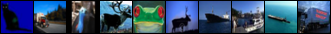

Train accuracy of car = 48.16%
Hard negatives for car


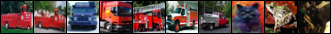

Train accuracy of bird = 30.00%
Hard negatives for bird


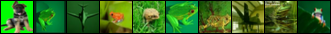

Train accuracy of cat = 28.36%
Hard negatives for cat


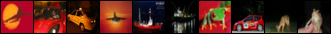

Train accuracy of deer = 28.94%
Hard negatives for deer


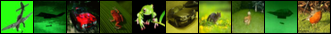

Train accuracy of dog = 34.14%
Hard negatives for dog


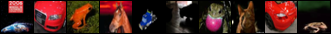

Train accuracy of frog = 38.68%
Hard negatives for frog


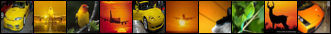

Train accuracy of horse = 53.12%
Hard negatives for horse


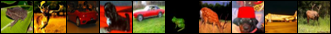

Train accuracy of ship = 42.20%
Hard negatives for ship


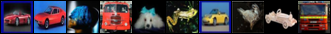

Train accuracy of truck = 26.20%
Hard negatives for truck


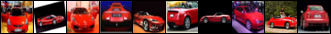


Test accuracy of the network: 35.64%
Test accuracy of plane = 65.00%
Hard negatives for plane


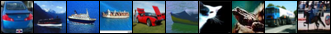

Test accuracy of car = 41.20%
Hard negatives for car


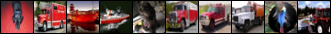

Test accuracy of bird = 26.60%
Hard negatives for bird


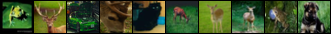

Test accuracy of cat = 24.30%
Hard negatives for cat


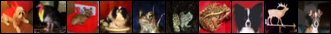

Test accuracy of deer = 25.10%
Hard negatives for deer


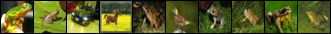

Test accuracy of dog = 28.40%
Hard negatives for dog


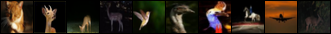

Test accuracy of frog = 36.20%
Hard negatives for frog


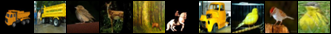

Test accuracy of horse = 48.70%
Hard negatives for horse


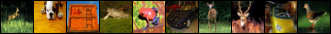

Test accuracy of ship = 39.00%
Hard negatives for ship


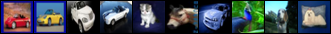

Test accuracy of truck = 21.90%
Hard negatives for truck


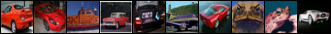


Epoch 5 summary -- loss = 1.781



Epoch 6 summary -- loss = 1.775



Epoch 7 summary -- loss = 1.806



Epoch 8 summary -- loss = 1.782



Epoch 9 summary -- loss = 1.784
Evaluating epoch 10



Train accuracy of the network: 40.06%
Train accuracy of plane = 46.00%
Hard negatives for plane


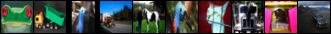

Train accuracy of car = 47.64%
Hard negatives for car


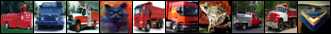

Train accuracy of bird = 21.98%
Hard negatives for bird


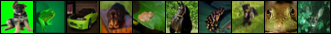

Train accuracy of cat = 22.10%
Hard negatives for cat


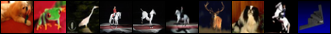

Train accuracy of deer = 34.64%
Hard negatives for deer


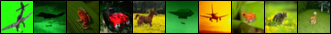

Train accuracy of dog = 48.14%
Hard negatives for dog


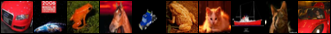

Train accuracy of frog = 41.82%
Hard negatives for frog


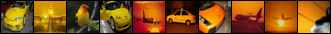

Train accuracy of horse = 39.76%
Hard negatives for horse


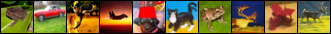

Train accuracy of ship = 49.62%
Hard negatives for ship


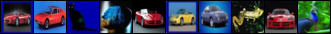

Train accuracy of truck = 48.94%
Hard negatives for truck


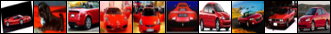


Test accuracy of the network: 35.06%
Test accuracy of plane = 41.60%
Hard negatives for plane


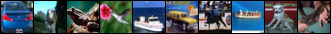

Test accuracy of car = 40.10%
Hard negatives for car


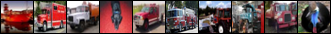

Test accuracy of bird = 19.30%
Hard negatives for bird


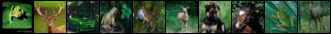

Test accuracy of cat = 16.20%
Hard negatives for cat


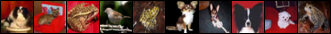

Test accuracy of deer = 28.60%
Hard negatives for deer


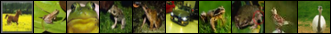

Test accuracy of dog = 39.40%
Hard negatives for dog


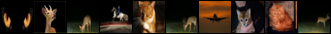

Test accuracy of frog = 39.40%
Hard negatives for frog


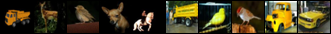

Test accuracy of horse = 36.80%
Hard negatives for horse


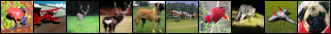

Test accuracy of ship = 46.40%
Hard negatives for ship


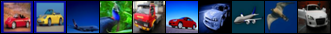

Test accuracy of truck = 42.80%
Hard negatives for truck


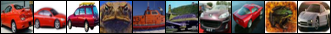

In [ ]:
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=15,
    eval_interval=5,
    batch_size=1024)

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)

## 2.2. Training a classifier using multiple fully connected layers ##

Implement a model for the same classification task using multiple fully connected layers.

Start with a fully connected layer that maps the data from image size (32 * 32 * 3) to a vector of size 120, followed by another fully connected that reduces the size to 84 and finally a layer that maps the vector of size 84 to 10 classes.

Use any activation you want.

Fill in the code for BoringNet below.

In [ ]:
class BoringNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.boring_layer = nn.Sequential(
            nn.Linear(32*32*3, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        return self.boring_layer(x.view(x.size(0), -1))

net = BoringNet()
net

### Run the model for 30 epochs and report the plots and accuracies.

In [ ]:
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)

### Question

Try training this model with and without activations. How does the activations (such as ReLU) affect the training process and why?


*TODO: Your answer here.*


## 2.3. Training a classifier using convolutions ##

Implement a model using convolutional, pooling and fully connected layers.

You are free to choose any parameters for these layers (we would like you to play around with some values).

Fill in the code for CoolNet below. Explain why you have chosen these layers and how they affected the performance. Analyze the behavior of your model.

In [ ]:
class CoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define model here
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        # TODO: Implement forward pass for LazyNet
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CoolNet()
net

### Run the model for 30 epochs and report the plots and accuracies 

In [ ]:
net = CoolNet()
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)

### 2.3.1. How does batch size affect training?

Try using three different values for batch size. How do these values affect training and why?

In [ ]:
net = CoolNet()
# TODO: Your code here

### 2.3.2. How does learning rate work?

When you are trying to train a neural network it is really hard to choose a proper learning rate. 

Try to train your model with different learning rates and plot the training accuracy, test accuracy and loss and compare the training progress for learning rates = 10, 0.1, 0.01, 0.0001.

Analyze the results and choose the best one. Why did you choose this value?



In [ ]:
net = CoolNet()
# TODO: Your code here

**Question**:
Analyze the results and choose one value to use. Why did you choose this value?

*TODO: Your answer here.*

### 2.3.3. Learning rate scheduling
During training it is often useful to reduce learning rate as the training progresses.

Fill in `set_learning_rate` below to scale the learning rate by 0.1 (reduce by 90%) every 30 epochs and observe the behavior of network for 90 epochs. 


In [ ]:
def set_learning_rate(optimizer, epoch, base_lr):
    # TODO: adjust learning rate here
    # lr = ...
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
net = CoolNet()
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    lr_func=set_learning_rate,
    criterion=nn.CrossEntropyLoss(),
    lr=0.01, 
    epochs=90, 
    batch_size=1024)

**Question**: 
What do you observe? Why do you think it is useful to decrease the learning rate over time?

*TODO: Your answer here.*

### 2.3.4. Data Augmentation

Most of the popular computer vision datasets have tens of thousands of images. 

Cifar-10 is a dataset of 60000 32x32 colour images in 10 classes, which can be relatively small in compare to ImageNet which has 1M images. 

The more the number of parameters is, the more likely our model is to overfit to the small dataset. 
As you might have already faced this issue while training the CoolNet, after some iterations the training accuracy reaches its maximum (saturates) while the test accuracy is still relatively low. 

To solve this problem, we use the data augmentation to help the network avoid overfitting.

Add data transformations in to the class below and compare the results. You are free to use any type and any number of data augmentation techniques.

Just be aware that data augmentation should just happen during training phase. 

In [ ]:
train_transform = transforms.Compose([
    # TODO: Add data augmentations here
    # You can find a list of transforms here:
    #  https://pytorch.org/docs/stable/torchvision/transforms.html
    transforms.ToTensor(),
    # Normalize rescales and shifts the data so that it has a zero mean 
    # and unit variance. This reduces bias and makes it easier to learn!
    # The values here are the mean and variance of our inputs.
    # This will change the input images to be centered at 0 and be 
    # between -1 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
net = CoolNet()
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=nn.CrossEntropyLoss(),
    train_transforms=train_transform,
    lr=0.01, 
    epochs=30, 
    batch_size=1024)

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)

**Question**: How does the model trained with data augmentation compared to the model trained without?

*TODO: Your answer here.*

### 2.3.5. Change the loss function

Try Mean Squared Error loss instead of Cross Entropy.

In [ ]:
class MSELossClassification(nn.Module):
  def forward(self, output, labels):
    one_hot_encoded_labels = \
      torch.nn.functional.one_hot(labels, num_classes=output.shape[1]).float()
    return nn.functional.mse_loss(output, one_hot_encoded_labels)

net = CoolNet()
train_losses, train_accuracies, test_accuracies = train_network(
    net, 
    criterion=MSELossClassification(),
    lr=0.01, 
    epochs=50, 
    batch_size=1024)

In [ ]:
plot_results(train_losses, train_accuracies, test_accuracies)

**Question**:
How does this affects the results? Explain why you think this is happening.

*TODO: Your answer here.*

## Turning In

You're done! You just need to turn in the notebook file.

Go to `File > Download .ipynb` and download the file as `hw4.ipynb`. Turn in only this file.

Make sure that you've answered all questions and all plots are correct.